# Eminem RNN

## Imports

In [490]:
import pandas as pd
import numpy as np
import random
import keras
import nltk
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import preprocessing
from keras.preprocessing.text import Tokenizer, one_hot, hashing_trick
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, Flatten, Dense, Dropout, SimpleRNN, GRU, LSTM # if GPU version, check out CUDNN
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec, KeyedVectors

### Data/EDA/Organizing

In [368]:
lyrics_by_song_with_headers = pd.read_csv('./Eminem Lyrics with Headers', index_col=0)

In [369]:
lyrics_by_song_without_headers = pd.read_csv('./Eminem Lyrics without Headers', index_col=0)

In [370]:
f = open('lyrics_eminem.txt', 'r')

with open('lyrics_eminem.txt', 'r') as f:
    raw_data = f.read()

split_data = raw_data.split('\n')

lyrics_by_line = pd.DataFrame(split_data)

lyrics_by_line.columns = ['Eminem Lyrics by Line']

lyrics_by_line # each sample as a row as in each line is a sample which is why we have so many compared to whole songs

,Eminem Lyrics by Line
0,"""Look, I was gonna go easy on you not to hurt ..."
1,"""But I'm only going to get this one chance."""
2,"""Something's wrong, I can feel it."""
3,"""Just a feeling I've got. Like something's abo..."
4,"If that means what I think it means, we're in ..."
...,...
26134,This shit won't even get me to The Shelter
26135,And I can't even say I'm from Motown
26136,'Cause I'm back in the 810 now
26137,'Cause I live at home in a trailer


In [371]:
lyrics_by_song_with_headers # each sample as a row as in each song is a sample

,lyrics
1996 Underground Freestyle,Any rapper saying those kind of rhymes In this...
"1997 Freestyle Live at Wetlands, NYC","[Verse 1] Everybody, duck down, all you hear i..."
1997 Rap Olympics,[RAP BATTLE 1] I'ma tell you this for your own...
1999,"[Intro] Hi kids, do you like Kim's bullshit? (..."
1999 Tim Westwood Freestyle,"[Verse 1: Eminem] Tim Westwood, Marley Marl an..."
...,...
Yellow Brick Road,"[Intro] ""What we have to do is deal with it wh..."
You Don’t Know,[Intro: Tony Yayo & 50 Cent] Shady! Yeah [Cho...
You Gon’ Learn,[Chorus: White Gold] Pray you see tomorrow lit...
You’re Never Over,"[Chorus] The days are cold, livin' without you..."


In [372]:
#lyrics_by_song_with_headers['y'] = lyrics_by_song_with_headers['lyrics'] + ??

In [373]:
lyrics_by_song_without_headers # each sample as a row as in each song is a sample

,lyrics
1996 Underground Freestyle,Any rapper saying those kind of rhymes In this...
"1997 Freestyle Live at Wetlands, NYC","Everybody, duck down, all you hear is the soun..."
1997 Rap Olympics,I'ma tell you this for your own benefit Your s...
1999,"Hi kids, do you like Kim's bullshit? (No!) Wan..."
1999 Tim Westwood Freestyle,"Tim Westwood, Marley Marl and Slim Shady and M..."
...,...
Yellow Brick Road,"""What we have to do is deal with it when these..."
You Don’t Know,"Shady! Yeah Who run it? You know, you actin' ..."
You Gon’ Learn,"Pray you see tomorrow little boy, you gon' lea..."
You’re Never Over,"The days are cold, livin' without you The nigh..."


## Setting X & y

In [374]:
X = lyrics_by_song_with_headers
X # lyrics_by_song_with_headers['lyrics']

,lyrics
1996 Underground Freestyle,Any rapper saying those kind of rhymes In this...
"1997 Freestyle Live at Wetlands, NYC","[Verse 1] Everybody, duck down, all you hear i..."
1997 Rap Olympics,[RAP BATTLE 1] I'ma tell you this for your own...
1999,"[Intro] Hi kids, do you like Kim's bullshit? (..."
1999 Tim Westwood Freestyle,"[Verse 1: Eminem] Tim Westwood, Marley Marl an..."
...,...
Yellow Brick Road,"[Intro] ""What we have to do is deal with it wh..."
You Don’t Know,[Intro: Tony Yayo & 50 Cent] Shady! Yeah [Cho...
You Gon’ Learn,[Chorus: White Gold] Pray you see tomorrow lit...
You’re Never Over,"[Chorus] The days are cold, livin' without you..."


In [426]:
X_no_headers = lyrics_by_song_without_headers
X_no_headers

,lyrics
1996 Underground Freestyle,Any rapper saying those kind of rhymes In this...
"1997 Freestyle Live at Wetlands, NYC","Everybody, duck down, all you hear is the soun..."
1997 Rap Olympics,I'ma tell you this for your own benefit Your s...
1999,"Hi kids, do you like Kim's bullshit? (No!) Wan..."
1999 Tim Westwood Freestyle,"Tim Westwood, Marley Marl and Slim Shady and M..."
...,...
Yellow Brick Road,"""What we have to do is deal with it when these..."
You Don’t Know,"Shady! Yeah Who run it? You know, you actin' ..."
You Gon’ Learn,"Pray you see tomorrow little boy, you gon' lea..."
You’re Never Over,"The days are cold, livin' without you The nigh..."


In [376]:
X_by_line = lyrics_by_line['Eminem Lyrics by Line']

X_by_line

0        "Look, I was gonna go easy on you not to hurt ...
1            "But I'm only going to get this one chance." 
2                     "Something's wrong, I can feel it." 
3        "Just a feeling I've got. Like something's abo...
4        If that means what I think it means, we're in ...
                               ...                        
26134           This shit won't even get me to The Shelter
26135                 And I can't even say I'm from Motown
26136                       'Cause I'm back in the 810 now
26137                   'Cause I live at home in a trailer
26138                          Mom, I'm comin' home to you
Name: Eminem Lyrics by Line, Length: 26139, dtype: object

In [377]:
len(raw_data)

1160852

In [378]:
type(raw_data)

str

In [379]:
y = lyrics_by_song_with_headers

In [380]:
y

,lyrics
1996 Underground Freestyle,Any rapper saying those kind of rhymes In this...
"1997 Freestyle Live at Wetlands, NYC","[Verse 1] Everybody, duck down, all you hear i..."
1997 Rap Olympics,[RAP BATTLE 1] I'ma tell you this for your own...
1999,"[Intro] Hi kids, do you like Kim's bullshit? (..."
1999 Tim Westwood Freestyle,"[Verse 1: Eminem] Tim Westwood, Marley Marl an..."
...,...
Yellow Brick Road,"[Intro] ""What we have to do is deal with it wh..."
You Don’t Know,[Intro: Tony Yayo & 50 Cent] Shady! Yeah [Cho...
You Gon’ Learn,[Chorus: White Gold] Pray you see tomorrow lit...
You’re Never Over,"[Chorus] The days are cold, livin' without you..."


# BIGGER NOTE?!: CAN WE SEQUENCE LYRICS BY SONG WITH SEQUENCE TO MATRIX WITH KERAS TOKENIZER CLASS

# Note: We want X to be our vectorized data and for y to be our successful regular text/lyrics, so X and y will be equal before vectorizing, right?!?!?!??????

In [381]:
len([i for i in X.values])

562

In [382]:
len([str(i) for i in X.values])

562

In [383]:
songs = [str(i) for i in X.values] # this gives me 562 strings (each individual string is a song)

In [387]:
songs[0]

'["Any rapper saying those kind of rhymes In this day and age in this period of time Tryna battle Eminem is worse than David Starr tryna battle Proof, Eye-Ku, BFlat and Bizarre (unintelligible) That\'s why you beg to differ me, you ain\'t got no style Plus you lack delivery, not to brag I don\'t need to boast Look, my face is pale, but you look like you seen a ghost (unintelligible) You couldn\'t slip up in the zone, if I put banana peels Around this fucking microphone So get a bulldozer, start from bottom to top And tear this building down \'cause that\'s the only way you wrecking shop"]'

# Word2Vec with nltk tokenizing

In [479]:
#nltk.download('punkt')

In [480]:
lyrics_to_word2vec = X_no_headers['lyrics'].values # for Word2Vec purposes no headers in lyrics

In [481]:
lyrics_to_word2vec = [nltk.word_tokenize(str(lyrics).lower()) for lyrics in lyrics_to_word2vec]

In [482]:
raw_lyrics_to_word2vec = nltk.word_tokenize(raw_data.lower())

In [483]:
raw_model = Word2Vec(lyrics_to_word2vec, min_count = 5, size=100)

In [484]:
model = Word2Vec(lyrics_to_word2vec, min_count = 5, size=100)

In [485]:
model.vector_size

100

In [517]:
model.wv.most_similar('eminem', topn=25)

[('berman', 0.9427893161773682),
 ('angie', 0.9325332641601562),
 (':', 0.9294376373291016),
 ('announcer', 0.9038035869598389),
 ('steve', 0.9032543301582336),
 ('ken', 0.8960354924201965),
 ('dre', 0.8953075408935547),
 ('mathers', 0.889751672744751),
 ('dr.', 0.8865886330604553),
 ('umm', 0.8863165974617004),
 ('kaniff', 0.8849854469299316),
 ('chicka', 0.8837929964065552),
 ('...', 0.8802132606506348),
 ('hi', 0.8791553378105164),
 ('marshall', 0.8590892553329468),
 ('driver', 0.8579820394515991),
 ('uh', 0.8576623797416687),
 ('um', 0.8504968881607056),
 ('brian', 0.8467622399330139),
 ('ha', 0.8452956676483154),
 ('1', 0.844970703125),
 ('aight', 0.8438528776168823),
 ('maxine', 0.8437789678573608),
 ('hey', 0.841982901096344),
 ('“', 0.8402076959609985)]

In [487]:
raw_model.wv.most_similar('eminem', topn=25)

[('berman', 0.9464727640151978),
 (':', 0.9286488890647888),
 ('...', 0.9210412502288818),
 ('steve', 0.9209773540496826),
 ('announcer', 0.9148417711257935),
 ('angie', 0.9146586060523987),
 ('dre', 0.9026294946670532),
 ('umm', 0.8950366973876953),
 ('marshall', 0.8914074897766113),
 ('mathers', 0.887453556060791),
 ('hi', 0.8818657398223877),
 ('dr.', 0.8783910870552063),
 ('um', 0.8735678195953369),
 ('teller', 0.8707593679428101),
 ('aww', 0.8674241304397583),
 ('royce', 0.8629127740859985),
 ('chicka', 0.8619462251663208),
 ('hey', 0.8582836389541626),
 ("5'9", 0.8573271632194519),
 ('ken', 0.8561680316925049),
 ('heck', 0.8516170978546143),
 ('kaniff', 0.8497159481048584),
 ('shaggy', 0.8453469276428223),
 ('brian', 0.8449128866195679),
 ('uh', 0.8440535664558411)]

# Visualization T-sne | Code modified from: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

In [569]:
keys = ['eminem', 'fuck', 'dick', 'bitch', 'drugs', 'ass', 'violence', 'mom']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in raw_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(raw_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/Users/dylanlunde/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [570]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

<Figure size 432x288 with 0 Axes>

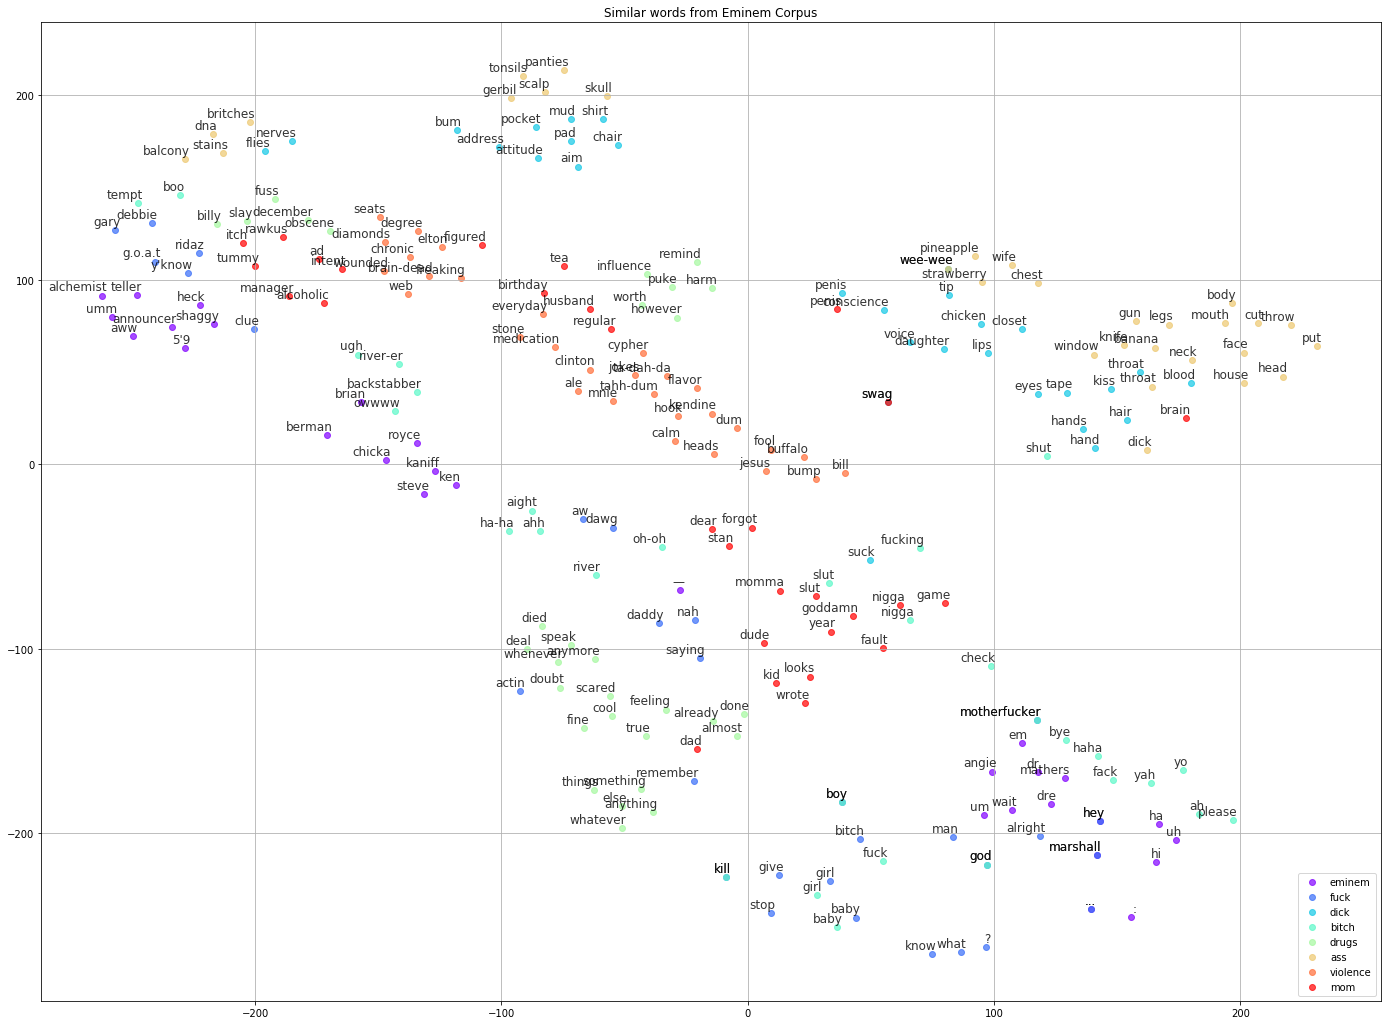

In [575]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(24, 18))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()

plt.savefig('Similar Words t-sne.png')
tsne_plot_similar_words('Similar words from Eminem Corpus', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [533]:
words_ak = []
embeddings_ak = []
for word in list(raw_model.wv.vocab):
    embeddings_ak.append(raw_model.wv[word])
    words_ak.append(word)
    
tsne_ak_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings_ak)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Eminem Corpus', embeddings_ak_2d, a=0.1)


KeyboardInterrupt: 

/Users/dylanlunde/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


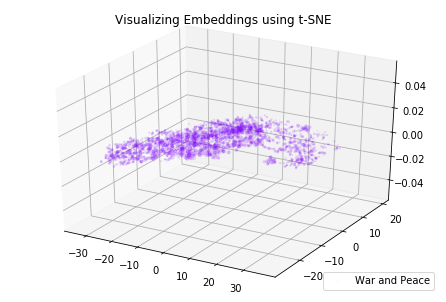

In [498]:
words_wp = []
embeddings_wp = []
for word in list(raw_model.wv.vocab):
    embeddings_wp.append(raw_model.wv[word])
    words_wp.append(word)
    
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Eminem Lyrics Corpus', embeddings_wp_3d, a=0.1)

# Embedding/Pre-Processing/Encoding Text Data/Lyrics with Keras

In [305]:
max_len = 1,560 # most words in a single song
training_samples = len(songs) # I want to train the model on every song
max_words = 21_000

In [306]:
t = Tokenizer(num_words=max_words) # instantiating Tokenizer class.

In [520]:
t.document_count

3934

In [475]:
t.fit_on_texts(songs) # fitting tokenizer to my corpus

song_sequences = t.texts_to_sequences(songs) # creating a list of sequences of integers out of my list of strings/lyrics
song_matrix = t.sequences_to_matrix(song_sequences)
one_hot_lyrics = t.texts_to_matrix(songs, mode='binary') # one hot encoded vectors
cvec_lyrics = t.texts_to_matrix(songs, mode='count') # count vectors
tfidf_lyrics = t.texts_to_matrix(songs, mode='tfidf') # tfidf vectors
# above is my vectorized data of songs. can we use this as our x to train a model and then predict a new y?

word_index = t.word_index # saving my token/word index to a variable. word_index is a dict

print(f'Found {len(word_index)} unique tokens/words.')

Found 20060 unique tokens/words.


In [526]:
len(word_index.keys())

20060

In [525]:
word_index

{True: 1,
 'i': 2,
 'the': 3,
 'you': 4,
 'a': 5,
 'and': 6,
 'to': 7,
 'it': 8,
 "'": 9,
 'my': 10,
 'in': 11,
 'me': 12,
 "'s": 13,
 'that': 14,
 'of': 15,
 "'t": 16,
 "'m": 17,
 'like': 18,
 'on': 19,
 'your': 20,
 'this': 21,
 'with': 22,
 'just': 23,
 'but': 24,
 'is': 25,
 'up': 26,
 'so': 27,
 'get': 28,
 'be': 29,
 'for': 30,
 'what': 31,
 'we': 32,
 'can': 33,
 'no': 34,
 'all': 35,
 'don': 36,
 'when': 37,
 'they': 38,
 'out': 39,
 'eminem': 40,
 'got': 41,
 'know': 42,
 'shit': 43,
 "i'm": 44,
 'if': 45,
 'do': 46,
 'at': 47,
 'he': 48,
 'was': 49,
 'back': 50,
 'now': 51,
 'fuck': 52,
 'verse': 53,
 'as': 54,
 'go': 55,
 'not': 56,
 "'cause": 57,
 'one': 58,
 'from': 59,
 "'re": 60,
 'off': 61,
 'yeah': 62,
 'see': 63,
 'his': 64,
 'say': 65,
 'never': 66,
 'who': 67,
 "'ll": 68,
 'or': 69,
 'have': 70,
 'her': 71,
 'man': 72,
 'down': 73,
 'ain': 74,
 'how': 75,
 'are': 76,
 'bitch': 77,
 "'em": 78,
 'oh': 79,
 'shady': 80,
 'chorus': 81,
 'time': 82,
 "don't": 83,
 'then'

In [344]:
len(song_sequences)

562

In [345]:
type(song_sequences) # list of integers

list

In [346]:
type(song_matrix)

numpy.ndarray

In [347]:
len(song_matrix)

562

In [316]:
print(f'Word Counts: {t.word_counts}')
print(f'Document Count: {t.document_count}')
print(f'Word Index: {t.word_index}')
print(f'Word Docs: {t.word_docs}')

Word Counts: OrderedDict([('any', 380), ('rapper', 176), ('saying', 192), ('those', 252), ('kind', 168), ('of', 7256), ('rhymes', 154), ('in', 8852), ('this', 5434), ('day', 710), ('and', 16384), ('age', 44), ('period', 24), ('time', 1356), ('tryna', 316), ('battle', 150), ('eminem', 2738), ('is', 4898), ('worse', 164), ('than', 824), ('david', 18), ('starr', 6), ('proof', 350), ('eye', 124), ('ku', 2), ('bflat', 2), ('bizarre', 82), ('unintelligible', 6), ("that's", 444), ('why', 1070), ('you', 21466), ('beg', 28), ('to', 15852), ('differ', 14), ('me', 8802), ("ain't", 738), ('got', 2738), ('no', 3160), ('style', 140), ('plus', 138), ('lack', 32), ('delivery', 12), ('not', 2048), ('brag', 20), ('i', 31942), ("don't", 1322), ('need', 780), ('boast', 10), ('look', 870), ('my', 9150), ('face', 452), ('pale', 14), ('but', 4932), ('like', 6072), ('seen', 238), ('a', 16388), ('ghost', 42), ("couldn't", 56), ('slip', 72), ('up', 4668), ('the', 22766), ('zone', 30), ('if', 2566), ('put', 1010

In [349]:
data = pad_sequences(sequences=song_sequences, padding='post')
# transforming my list of sequences, 'sequences', into a 2D Numpy array with a maximum length of max_len and making all sequences same length

In [351]:
len(data)

562

In [352]:
data

array([[234, 480, 441, ...,   0,   0,   0],
       [ 53, 129, 177, ...,   0,   0,   0],
       [  9, 166, 546, ...,   0,   0,   0],
       ...,
       [  9,  81, 181, ...,   0,   0,   0],
       [  9,  81,   3, ...,   0,   0,   0],
       [  9,  53, 129, ...,   0,   0,   0]], dtype=int32)

#### Creating Embedding Layer for my Future Model out of the Word Index Created Above


In [332]:
embedding_layer = Embedding(len(word_index) + 1, 64, input_length=562)
# When I create my model I can add this layer to it

In [333]:
embedding_layer

# Train Test Split

In [285]:
X.shape # lyrics_by_song_with_headers['lyrics']

(562, 1)

In [286]:
y.shape

(562, 1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [276]:
X.shape

(562, 1)

In [277]:
X_train.shape

(421,)

In [278]:
X_test.shape

(141,)

In [281]:
X.values

array([["Any rapper saying those kind of rhymes In this day and age in this period of time Tryna battle Eminem is worse than David Starr tryna battle Proof, Eye-Ku, BFlat and Bizarre (unintelligible) That's why you beg to differ me, you ain't got no style Plus you lack delivery, not to brag I don't need to boast Look, my face is pale, but you look like you seen a ghost (unintelligible) You couldn't slip up in the zone, if I put banana peels Around this fucking microphone So get a bulldozer, start from bottom to top And tear this building down 'cause that's the only way you wrecking shop"],
       ["[Verse 1] Everybody, duck down, all you hear is the sound Of Slim Shady spittin' rounds at the Lyricist Lounge What year is this now? I don't know, I forgot All I know is that I'd die for pot, make the cypher hot Smoke weed and fuck up my life a lot Give me the money now, bitch Did you want to see your wife or not? 'Fore I stab her wit' this knife I got I got a sci-fi plot like a science fic